In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec = sns.color_palette("dana", n_colors=27)


# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana2", cmap)
phasecf = sns.color_palette("dana2", n_colors=27)

/tmp/ipykernel_32180/813501115.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_32180/813501115.py:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana2", cmap)


In [6]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [7]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
#male_df = male_df.query('age<100')

In [8]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)

In [9]:
# Group by 'bin' and 'mouse' and count the occurrences
#long_df.groupby(['age', 'mouse']).size().unstack(fill_value=0)
long_df = long_df.drop(index=['03_03', '02_04', '04_02'], level='mouse')
#long_df.groupby(['age', 'mouse']).size().unstack(fill_value=0)

In [10]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [11]:
df_indv=m_norm.groupby(['mouse','age']).mean()
df=df_indv.copy()

In [12]:
## from win

In [13]:
format_plots()

In [14]:
import matplotlib.colors as mpc
from scipy.spatial.distance import pdist, squareform

In [15]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in df.groupby('age'):
    inter_ind_dists = pdist(_df, metric='euclidean')
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age)))
iid_df = pd.concat(iid_df)
iid_avg_df = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


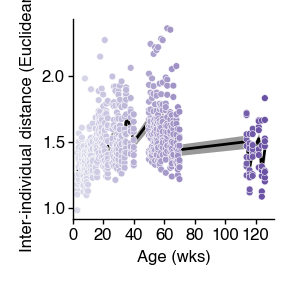

In [16]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
a = sns.lineplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a = sns.scatterplot(
    data=iid_avg_df,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a.set(
    #ylim=(0.0, 0.20),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (Euclidean)",
    xticks=[0,20,40,60,80,100,120],
)
sns.despine()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig5"/ 'inter_indv_long.pdf', bbox_inches='tight')

In [18]:
iid_avg_df

,iid,age
0,1.135302,3
1,1.174001,3
2,1.173167,3
3,1.180633,3
4,0.980118,3
...,...,...
4,1.664414,126
5,1.465701,126
6,1.523308,126
7,1.503022,126
